This is a tutorial on Text Generation using Deep Learning. Text Generation is the art of generating words or sentences which will follow the given input text.
Here, Long Short-term Memory(LSTM) model is used for the purpose which serves a vital role in preserving the context over long period of time.

The scope of this tutorial are as follows:

* Understanding Text Preprocessing
* Understanding Implementation in PyTorch
* Understanding solving NLP problems using Deep Learning
* Understanding the workflow of Sequence Models

Here is a nice tutorial on building models using PyTorch [Link](https://www.kaggle.com/ankitjha/the-ultimate-pytorch-guide)

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
!pip install pyspellchecker
import re 
from wordcloud import WordCloud, STOPWORDS
from spellchecker import SpellChecker
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from collections import Counter
%matplotlib inline
import torch.utils.data
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os

    100% |████████████████████████████████| 1.9MB 15.6MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
df = pd.read_csv('../input/Womens Clothing E-Commerce Reviews.csv')
df.dropna(inplace = True)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


We will concatenate all the text in the *Review Text* column to form a single string to learn the language model for generating predictions for possible candidates of words

In [3]:
# Function to check presence of a digit in a string
def contains_digit(string):
    return bool(re.search(r'\d', string))

# Text Preprocessing

The Text preprocessing involves following steps:

* Cleaning the text data(Removing extra fullstops and exclamation marks.)
* Removing numbers because these can affect the performance of the model and lead to a larger embedding size.
* Spell correction as review dataset contains many spelling mistakes. There are many spell correcting libraries. However, I have chosen [pyspellchecker](https://pypi.org/project/pyspellchecker/) which implements a simple spell checking algorithm designed by Peter Norvig.
* Converting data into lowercase

In [4]:
class TextPreprocessing:
    def __init__(self, train):
        self.text = ''
        self.cleaned_text = []
        self.input_text = ''
        self.train = train
        
    def gettext(self, df, colname, num_cols):
        if self.train == True:
            for line in df[colname].values[:num_cols]:
                self.text += line
        else:
            for line in df[colname].values[num_cols:]:
                self.text += line
    
    # Cleaning the text
    def clean_text(self):
        self.text = re.sub("([\(\[]).*?([\)\]])", "", self.text)
        fullstops = ['...', '..', '!!!', '!!', '!']
        for s in fullstops:
            self.text = self.text.replace(s, ".")
    
    # Removing sentences with digits
    def remove_numbers(self):
        for sentence in self.text.split('.'):
            if(contains_digit(sentence) == False):
                self.cleaned_text.append(sentence.rstrip())
        self.input_text = '.'.join(sentence for sentence in self.cleaned_text)
    
    # Spell correction of misspelled words
    def spell_correction(self):
        _spell = SpellChecker()
        incorrect_words = []
        correct_words = []
        res = re.findall(r'\w+', self.input_text) 
        for word in tqdm(set(res)):
            correct = _spell.correction(word)
            if(word != correct):
                incorrect_words.append(word)
                correct_words.append(correct)
        for i, word in enumerate(incorrect_words):
            self.input_text = self.input_text.replace(word, correct_words[i])
        self.input_text = self.input_text.replace('.', ' .')
        return self.input_text.lower()

In [5]:
text_data = TextPreprocessing(train = True)
text_data.gettext(df, 'Review Text', 200)
text_data.clean_text()
text_data.remove_numbers()
input_text = text_data.spell_correction()
# Here, input text contains the preprocessed text.
train_text = input_text.split()

valid_text_data = TextPreprocessing(False)
valid_text_data.gettext(df, 'Review Text', -100)
valid_text_data.clean_text()
valid_text_data.remove_numbers()
valid_input_text = valid_text_data.spell_correction()
valid_text = valid_input_text.split()

100%|██████████| 1052/1052 [00:28<00:00, 36.38it/s]


In [6]:
train_text[:15]

['i',
 'had',
 'such',
 'high',
 'hopes',
 'for',
 'this',
 'dress',
 'and',
 'really',
 'wanted',
 'it',
 'to',
 'work',
 'for']

Now, we got the data as a list of words. Here we need to find a representation of these sequence of words to feed into the model.

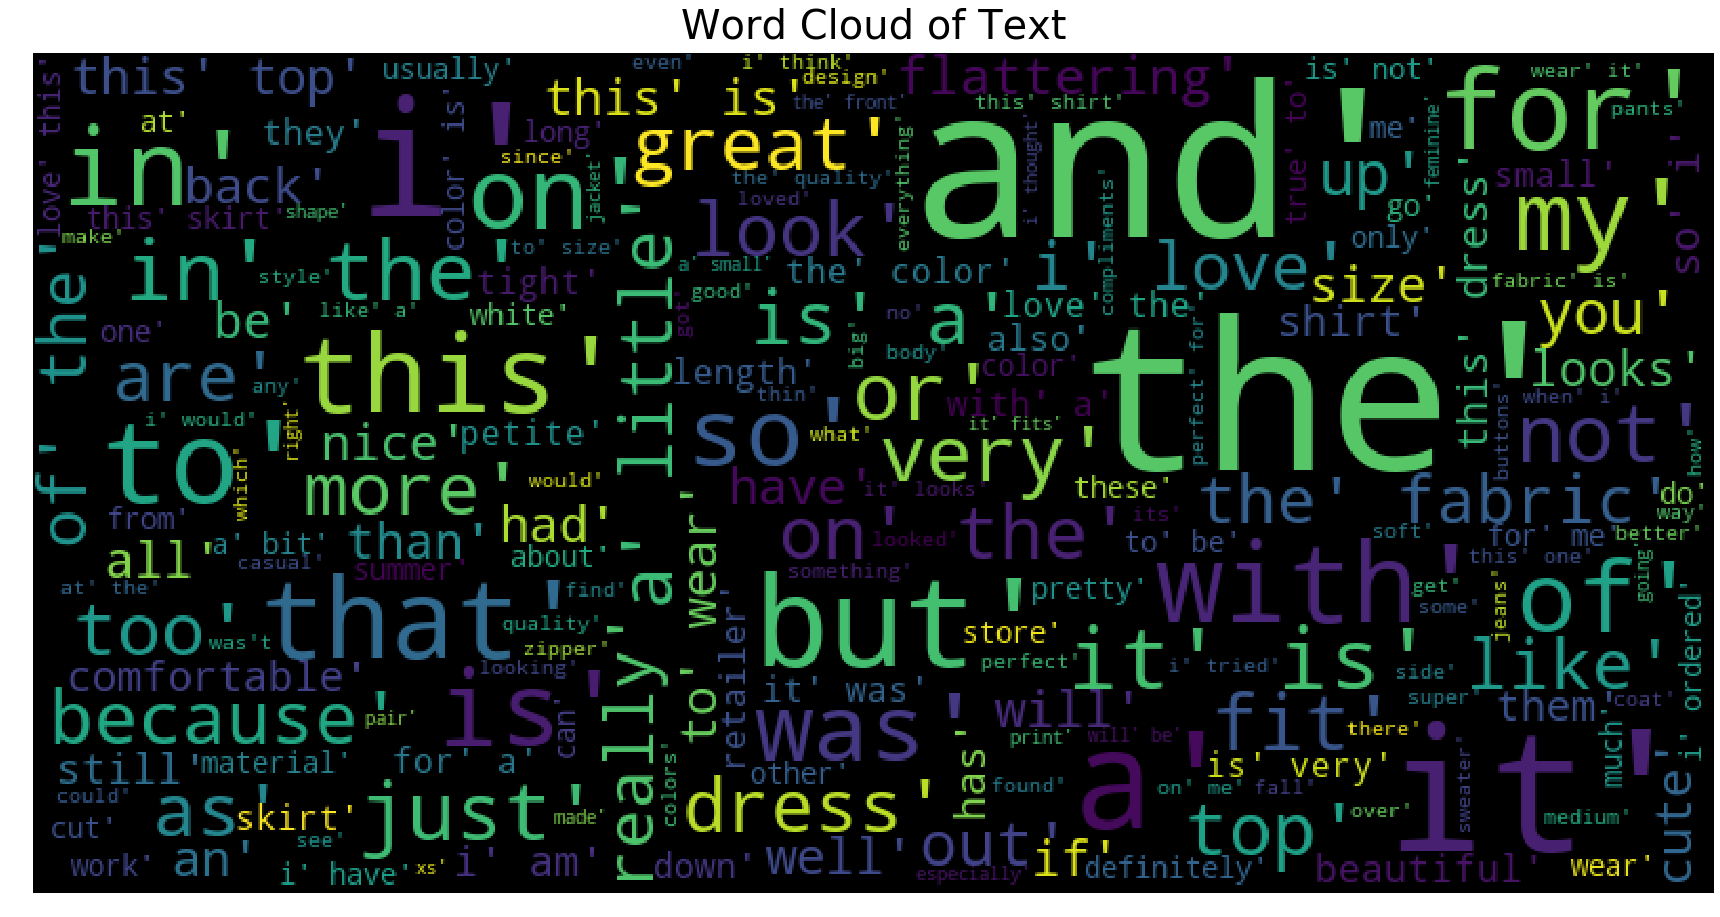

In [7]:
def wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
wordcloud(train_text, title="Word Cloud of Text")

# Feature Selection

Here as a feature represetation of the data, I am generating a representation of each of the word using a unique integer value. For example, this sentence *['I', 'am' , 'a', 'good', 'person', 'and', 'a', 'blogger']* can be represented as: *[0, 1, 2, 3, 4, 5, 2, 6]*

In [8]:
key_val = {}
val_key = {}
valid_key_val = {}
valid_val_key = {}
for i, key in enumerate(pd.value_counts(train_text).keys()):
    key_val[key] = i
    val_key[i] = key
    

for i, key in enumerate(pd.value_counts(valid_text).keys()):
    valid_key_val[key] = i
    valid_val_key[i] = key

In [9]:
{k: key_val[k] for k in list(key_val)[:5]}

{'.': 0, 'the': 1, 'and': 2, 'i': 3, 'it': 4}

In [10]:
{k: val_key[k] for k in list(val_key)[:5]}

{0: '.', 1: 'the', 2: 'and', 3: 'i', 4: 'it'}

In [11]:
batch_size = 16
timesteps = 32
train_arr = []
valid_arr = []
train_loss = []
valid_loss = []
num_epochs = 10
num_batches = int(len(train_text) / (batch_size * timesteps))
valid_num_batches = int(len(valid_text) / (batch_size * timesteps))

# Size of embedding
embedding_size = 64

# Number of units in LSTM Layer
num_lstm_units = 64

# Using cuda if present else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading in PyTorch

In [12]:
for word in train_text:
    train_arr.append(key_val[word])
    
# Reshaping data to pass into model
train_data = np.reshape(train_arr[:num_batches * batch_size * timesteps], (batch_size, -1)) 
target = np.reshape(np.append(train_data[1:], train_data[0]), (batch_size, -1))
for word in valid_text:
    valid_arr.append(valid_key_val[word])
validation_features = np.reshape(valid_arr[:valid_num_batches * batch_size * timesteps], (batch_size, -1))
validation_target = np.reshape(np.append(validation_features[1:], validation_features[0]), (batch_size, -1))

Let us have a look at how the train features look

In [13]:
print(train_data[:5])

[[   3   67  335 ...  609   25   44]
 [  58  131  653 ...   24    8   55]
 [  44   79    3 ...   47   10  130]
 [   2    4   74 ...  543    2    1]
 [1759    9    1 ...  210   57   60]]


In [14]:
print(target[:5])

[[  58  131  653 ...   24    8   55]
 [  44   79    3 ...   47   10  130]
 [   2    4   74 ...  543    2    1]
 [1759    9    1 ...  210   57   60]
 [  13  343  118 ...  215   43   61]]


While loading the data, these point should be closely worked upon:

* Setting a batch Size
* Shuffling the data
* Parallelizing the tasks using multiprocecssing workers. 

The DataLoader function provides all of these features and you can specify them before heading to next task

In [15]:
#converting torch data type into torch tensor
train = torch.from_numpy(train_data)
targets = torch.from_numpy(target) 

validation = torch.from_numpy(validation_features)
validation_target = torch.from_numpy(validation_target) 

train_set = torch.utils.data.TensorDataset(train,targets)
valid_set = torch.utils.data.TensorDataset(validation, validation_target)


#Loading data into Dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = False)
validation_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)

# Model Selection

Here, the feature vectors are passed through an LSTM layer followed by a dense layer. I have chosen a simple model just as a starter to check the performance.
LSTM is composed of input gate, cell, output gate and forget gate. These are responsible for regulating flow of information across timesteps.
An indepth tutorial on LSTM is explained [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
![LSTM](https://cdn-images-1.medium.com/max/1600/1*Niu_c_FhGtLuHjrStkB_4Q.png)

In [16]:
class Model(nn.Module):
    def __init__(self, num_words, timesteps, num_lstm_units, embedding_size):
        super(Model, self).__init__()
        self.timesteps = timesteps
        self.num_lstm_units = num_lstm_units
        self.embedding = nn.Embedding(num_words, embedding_size)
        self.lstm = nn.LSTM(embedding_size, num_lstm_units, num_layers = 1, batch_first=True)
        self.dense = nn.Linear(num_lstm_units, num_words)
        
    def forward(self, x, hidden_unit):
        embeddings = self.embedding(x)
        prediction, state = self.lstm(embeddings, hidden_unit)
        logits = self.dense(prediction)
        return logits, state

In [17]:
model = Model(len(train_arr), timesteps,
              embedding_size, num_lstm_units)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [18]:
# Function to train the model

def train(epoch):
    model.train()
    tr_loss = 0
    # initializing hidden state and cell state
    h_t, c_t = torch.zeros(1, batch_size, num_lstm_units), torch.zeros(1, batch_size, num_lstm_units)
    h_t.zero_()
    c_t.zero_()
    h_t, c_t = h_t.to(device), c_t.to(device)
    for batch_idx, (X_train, y) in enumerate(train_loader):
        X_train, y = Variable(X_train), Variable(y)
        if torch.cuda.is_available():
            X_train = X_train.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        logits, (h_t, c_t) = model(X_train, (h_t, c_t))
        loss = criterion(logits.transpose(1, 2), y)
        h_t = h_t.detach()
        c_t = c_t.detach()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(X_train), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

In [19]:
# Function to validate the model

def evaluate(data_loader):
    model.eval()
    h_t, c_t = torch.zeros(1, batch_size, num_lstm_units), torch.zeros(1, batch_size, num_lstm_units)
    h_t.zero_()
    c_t.zero_()
    h_t, c_t = h_t.to(device), c_t.to(device)
    loss = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.to(device)
            target = target.to(device)
        logits, (h_t, c_t) = model(data, (h_t, c_t))
        loss += criterion(logits.transpose(1, 2), target).item()
        
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    print('Validation loss: {:.5f}'.format(loss))

 # Model Training

In [20]:
n_epochs = 150
for epoch in range(n_epochs):
    train(epoch)
    evaluate(validation_loader)

Train Epoch: 0 [16/16 (100%)]	Loss: 9.344283
Validation loss: 0.58394
Train Epoch: 1 [16/16 (100%)]	Loss: 9.343413
Validation loss: 0.58388
Train Epoch: 2 [16/16 (100%)]	Loss: 9.342539
Validation loss: 0.58383
Train Epoch: 3 [16/16 (100%)]	Loss: 9.341669
Validation loss: 0.58377
Train Epoch: 4 [16/16 (100%)]	Loss: 9.340797
Validation loss: 0.58372
Train Epoch: 5 [16/16 (100%)]	Loss: 9.339927
Validation loss: 0.58366
Train Epoch: 6 [16/16 (100%)]	Loss: 9.339056
Validation loss: 0.58361
Train Epoch: 7 [16/16 (100%)]	Loss: 9.338184
Validation loss: 0.58355
Train Epoch: 8 [16/16 (100%)]	Loss: 9.337313
Validation loss: 0.58350
Train Epoch: 9 [16/16 (100%)]	Loss: 9.336442
Validation loss: 0.58344
Train Epoch: 10 [16/16 (100%)]	Loss: 9.335570
Validation loss: 0.58339
Train Epoch: 11 [16/16 (100%)]	Loss: 9.334698
Validation loss: 0.58333
Train Epoch: 12 [16/16 (100%)]	Loss: 9.333826
Validation loss: 0.58328
Train Epoch: 13 [16/16 (100%)]	Loss: 9.332954
Validation loss: 0.58322
Train Epoch: 14 

Train Epoch: 116 [16/16 (100%)]	Loss: 9.239608
Validation loss: 0.57732
Train Epoch: 117 [16/16 (100%)]	Loss: 9.238634
Validation loss: 0.57726
Train Epoch: 118 [16/16 (100%)]	Loss: 9.237659
Validation loss: 0.57719
Train Epoch: 119 [16/16 (100%)]	Loss: 9.236680
Validation loss: 0.57713
Train Epoch: 120 [16/16 (100%)]	Loss: 9.235701
Validation loss: 0.57707
Train Epoch: 121 [16/16 (100%)]	Loss: 9.234719
Validation loss: 0.57701
Train Epoch: 122 [16/16 (100%)]	Loss: 9.233734
Validation loss: 0.57695
Train Epoch: 123 [16/16 (100%)]	Loss: 9.232749
Validation loss: 0.57688
Train Epoch: 124 [16/16 (100%)]	Loss: 9.231762
Validation loss: 0.57682
Train Epoch: 125 [16/16 (100%)]	Loss: 9.230770
Validation loss: 0.57676
Train Epoch: 126 [16/16 (100%)]	Loss: 9.229777
Validation loss: 0.57669
Train Epoch: 127 [16/16 (100%)]	Loss: 9.228782
Validation loss: 0.57663
Train Epoch: 128 [16/16 (100%)]	Loss: 9.227784
Validation loss: 0.57657
Train Epoch: 129 [16/16 (100%)]	Loss: 9.226786
Validation loss: 

In [21]:
def plot_graphs(train_loss, valid_loss, epochs):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Train Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('train_loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Validation Loss")
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='test')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('vaidation _loss', fontsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='best')

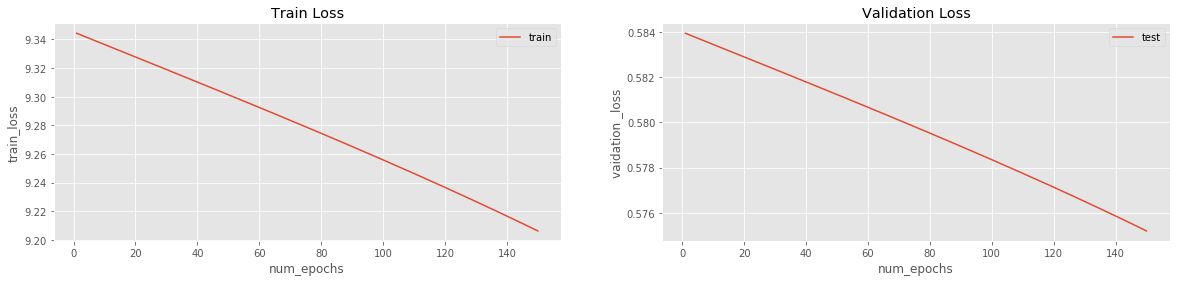

In [22]:
plot_graphs(train_loss, valid_loss, n_epochs)

In [23]:
model.eval()
h_t, c_t = torch.zeros(1, batch_size, num_lstm_units), torch.zeros(1, batch_size, num_lstm_units)
h_t.zero_()
c_t.zero_()
h_t, c_t = h_t.to(device), c_t.to(device) 
words = []
string = []
for (word, target_variable) in validation_loader:
    word = word.to(device)
    numpy_word = word.cpu().numpy()
    output, (h_t, c_t) = model(word, (h_t, c_t))
    words = numpy_word.ravel()
    predictions = torch.topk(output[0], k=3)[1].tolist()
    string.append(valid_val_key[predictions[0][0]])
    string.append(valid_val_key[predictions[0][1]])
    string.append(valid_val_key[predictions[0][2]])
    
print('The input string is: ')
input_string = []
for word in words[-25:-15]:
    input_string.append(valid_val_key[word])
s = ' '.join(input_string)
print(s)
print('The next word predictions are: ')
print(string)

The input string is: 
so impressed with the beautiful color combinations and embroidery but
The next word predictions are: 
['the', '.', 'i']


Future Tasks

* Fine tuning the network
* Developing other architectures